### Домашнее задание: Разработка дашборда с использованием Streamlit и нейронной сети для предсказания цен на жильё

### Цель:
Научиться создавать веб-приложения с использованием Streamlit, интегрировать нейронную сеть для предсказания данных и визуализировать результаты. Вы будете работать с моделью машинного обучения для предсказания цен на жильё, используя библиотеку PyTorch.

### Описание датасета

Датасет содержит информацию о квартирах, представленных для продажи. Датасет используется для обучения модели, которая предсказывает стоимость квартиры.

#### Структура датасета

- **Количество квартир в выборке**: N (замените N на фактическое количество квартир после фильтрации)

**Поля в датасете**:
- **Цена, тыс.руб.**: Цена квартиры в тысячах рублей.
- **Тип дома**: Тип здания, в котором находится квартира (например, кирпичный, панельный и т.д.).
- **Балконы**: Количество балконов.
- **Лоджии**: Количество лоджий.
- **Станция метро**: Название ближайшей станции метро.
- **Пешком или на транспорте**: Указание на то, добираться ли до метро пешком или на транспорте.
- **Время в пути**: Время в пути до ближайшей станции метро (в минутах).
- **Площадь**: Общая площадь квартиры в квадратных метрах.
- **Этаж**: Этаж, на котором находится квартира.
- **Всего этажей в доме**: Общее количество этажей в здании.
- **Санузел**: Наличие и тип санузла (совмещенный, раздельный и т.д.).
- **Тип санузла**: Тип санузла (например, совмещенный, раздельный).
- **Примечание**: Дополнительная информация о квартире.

**Общее количество признаков**: 12


### app.py

In [ ]:
import streamlit as st
import torch
import torch.nn as nn
import numpy as np

# Определение модели
# Данная модель была предварительно обучена в Google Colaboratory с использованием GPU T4.
# Модель представляет собой многослойную нейронную сеть, использующую LeakyReLU и Dropout для улучшения обучения.
class ImprovedRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedRegressionModel, self).__init__()
        # Последовательность слоев нейронной сети
        self.layer1 = nn.Linear(input_dim, 1024)  # Первый полносвязный слой
        self.layer2 = nn.Linear(1024, 512)       # Второй полносвязный слой
        self.layer3 = nn.Linear(512, 256)       # Третий полносвязный слой
        self.layer4 = nn.Linear(256, 128)       # Четвертый полносвязный слой
        self.layer5 = nn.Linear(128, 64)        # Пятый полносвязный слой
        self.layer6 = nn.Linear(64, 32)         # Шестой полносвязный слой
        self.layer7 = nn.Linear(32, 1)          # Выходной слой для регрессии
        self.leaky_relu = nn.LeakyReLU(0.1)     # Функция активации LeakyReLU
        self.dropout = nn.Dropout(0.3)          # Dropout для регуляризации

    def forward(self, x):
        # Последовательное применение слоев, функций активации и Dropout
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer5(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer6(x))
        x = self.layer7(x)  # На выходе возвращаем прогноз
        return x

# Загрузка модели
# Модель была сохранена в Google Colaboratory в формате torch.save(model, "model_full.pth").
# Здесь мы загружаем обученную модель для использования.
model_path = r"D:\NI_ComputerVision\L36\model_full.pth"
model = torch.load(model_path)  # Загрузка обученной модели
model.eval()  # Переводим модель в режим оценки (evaluation mode)

# Функция для предсказания
# Эта функция принимает на вход признаки квартиры и возвращает прогноз цены.
def predict(features):
    with torch.no_grad():  # Отключаем градиенты, так как мы только предсказываем
        inputs = torch.tensor(features, dtype=torch.float32)  # Преобразуем признаки в тензор
        prediction = model(inputs.unsqueeze(0))  # Добавляем измерение batch для совместимости с моделью
    return prediction.item()  # Возвращаем результат как число

# Интерфейс Streamlit
# Создаем заголовок и описание приложения
st.title("Прогноз цен на недвижимость")
st.write("Введите характеристики квартиры:")

# Ввод данных
# Интерфейс для ввода данных пользователем
балконы = st.slider("Количество балконов", 0, 5, 0)
лоджии = st.slider("Количество лоджий", 0, 5, 0)
время_в_пути = st.slider("Время в пути до метро (минуты)", 1, 60, 15)
площадь = st.number_input("Площадь квартиры (кв.м)", 10.0, 300.0, 50.0)
этаж = st.slider("Этаж", 1, 30, 5)
всего_этажей = st.slider("Всего этажей в доме", 1, 30, 10)

# Формирование признаков
# Преобразуем ввод пользователя в список признаков для модели
features = [
    балконы,
    лоджии,
    время_в_пути,
    площадь,
    этаж / всего_этажей,  # Нормализация этажа относительно количества этажей
]

# Заполнение недостающих признаков
# Если модель ожидает больше признаков, чем пользователь вводит, заполняем оставшиеся нулями
while len(features) < 1291:  # 1291 - это входное количество признаков для обученной модели
    features.append(0)

features = np.array(features, dtype=np.float32)  # Преобразуем список в массив NumPy для дальнейшей обработки

# Кнопка предсказания
# После нажатия кнопки вычисляется прогноз цены
if st.button("Прогнозировать цену"):
    цена = predict(features)  # Вызываем функцию предсказания
    st.success(f"Прогнозируемая цена: {цена:.2f} тыс. рублей")  # Отображаем результат пользователю


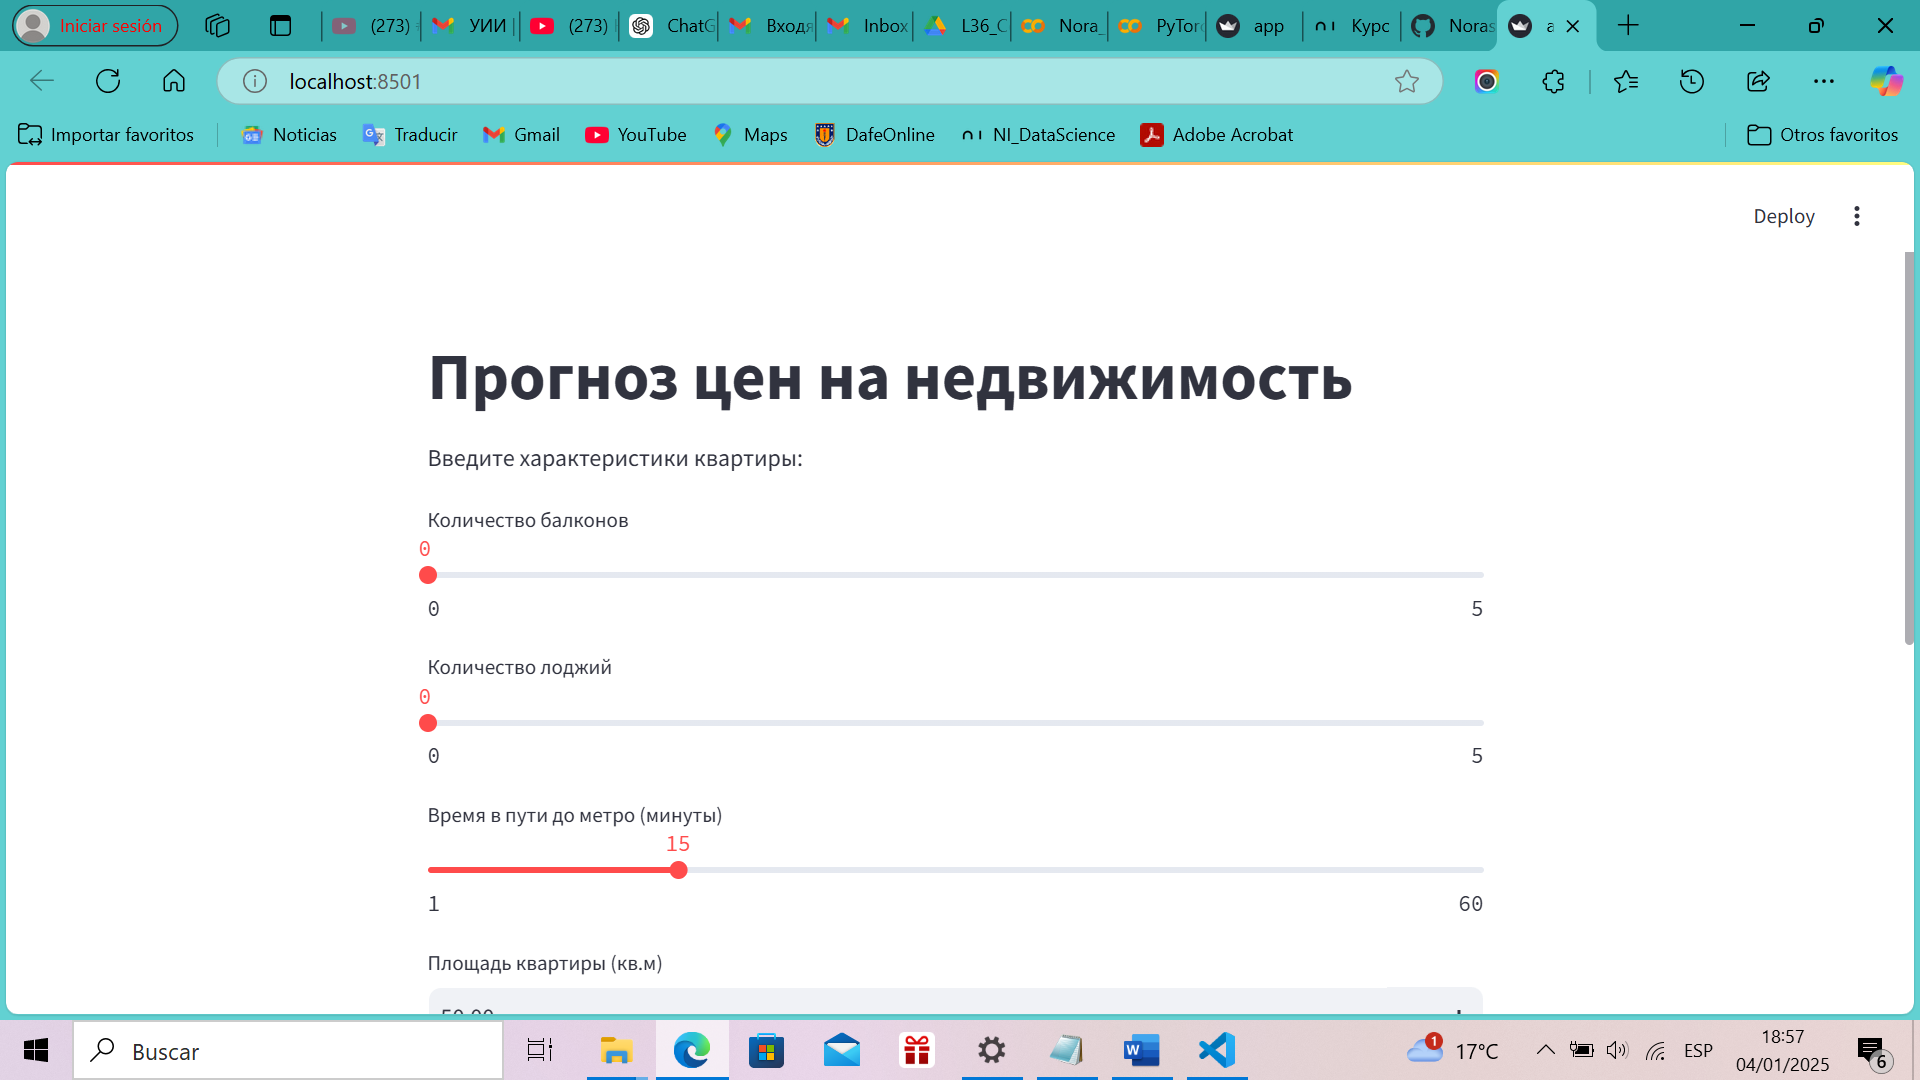

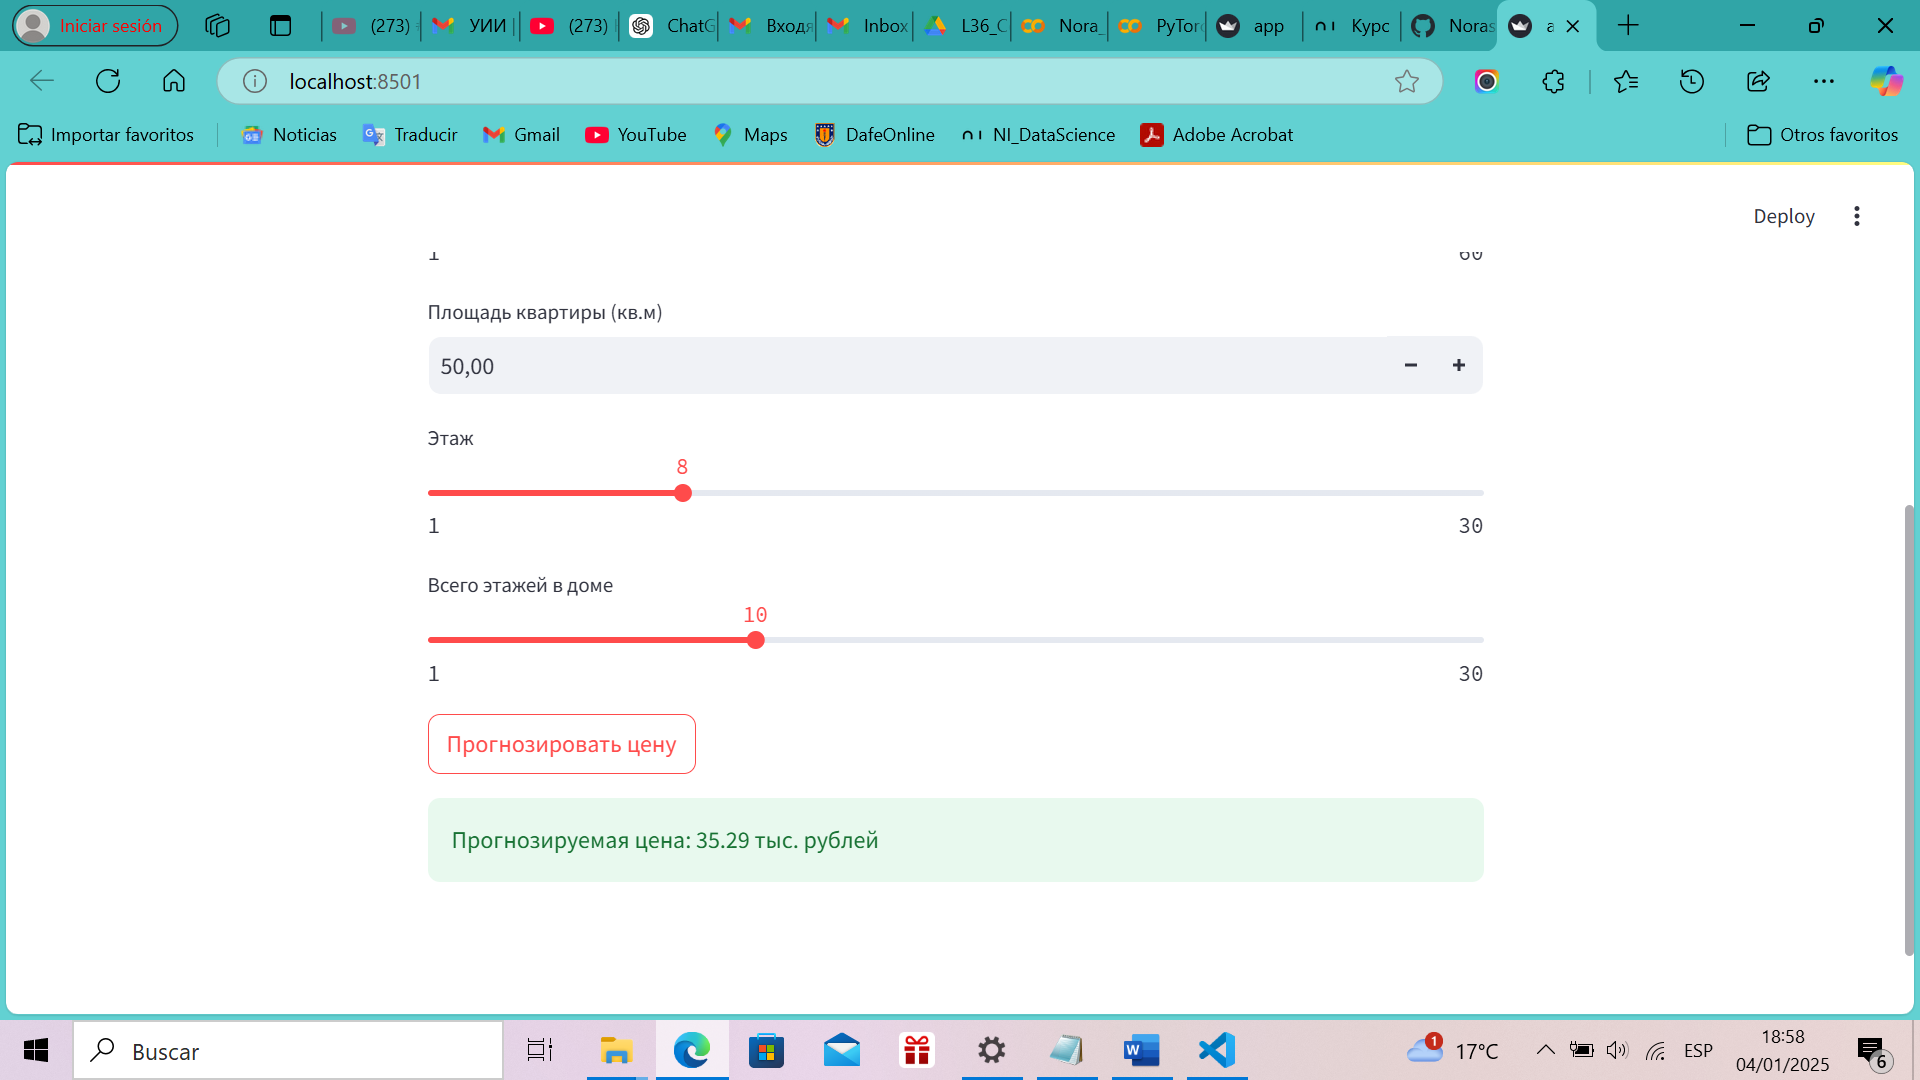

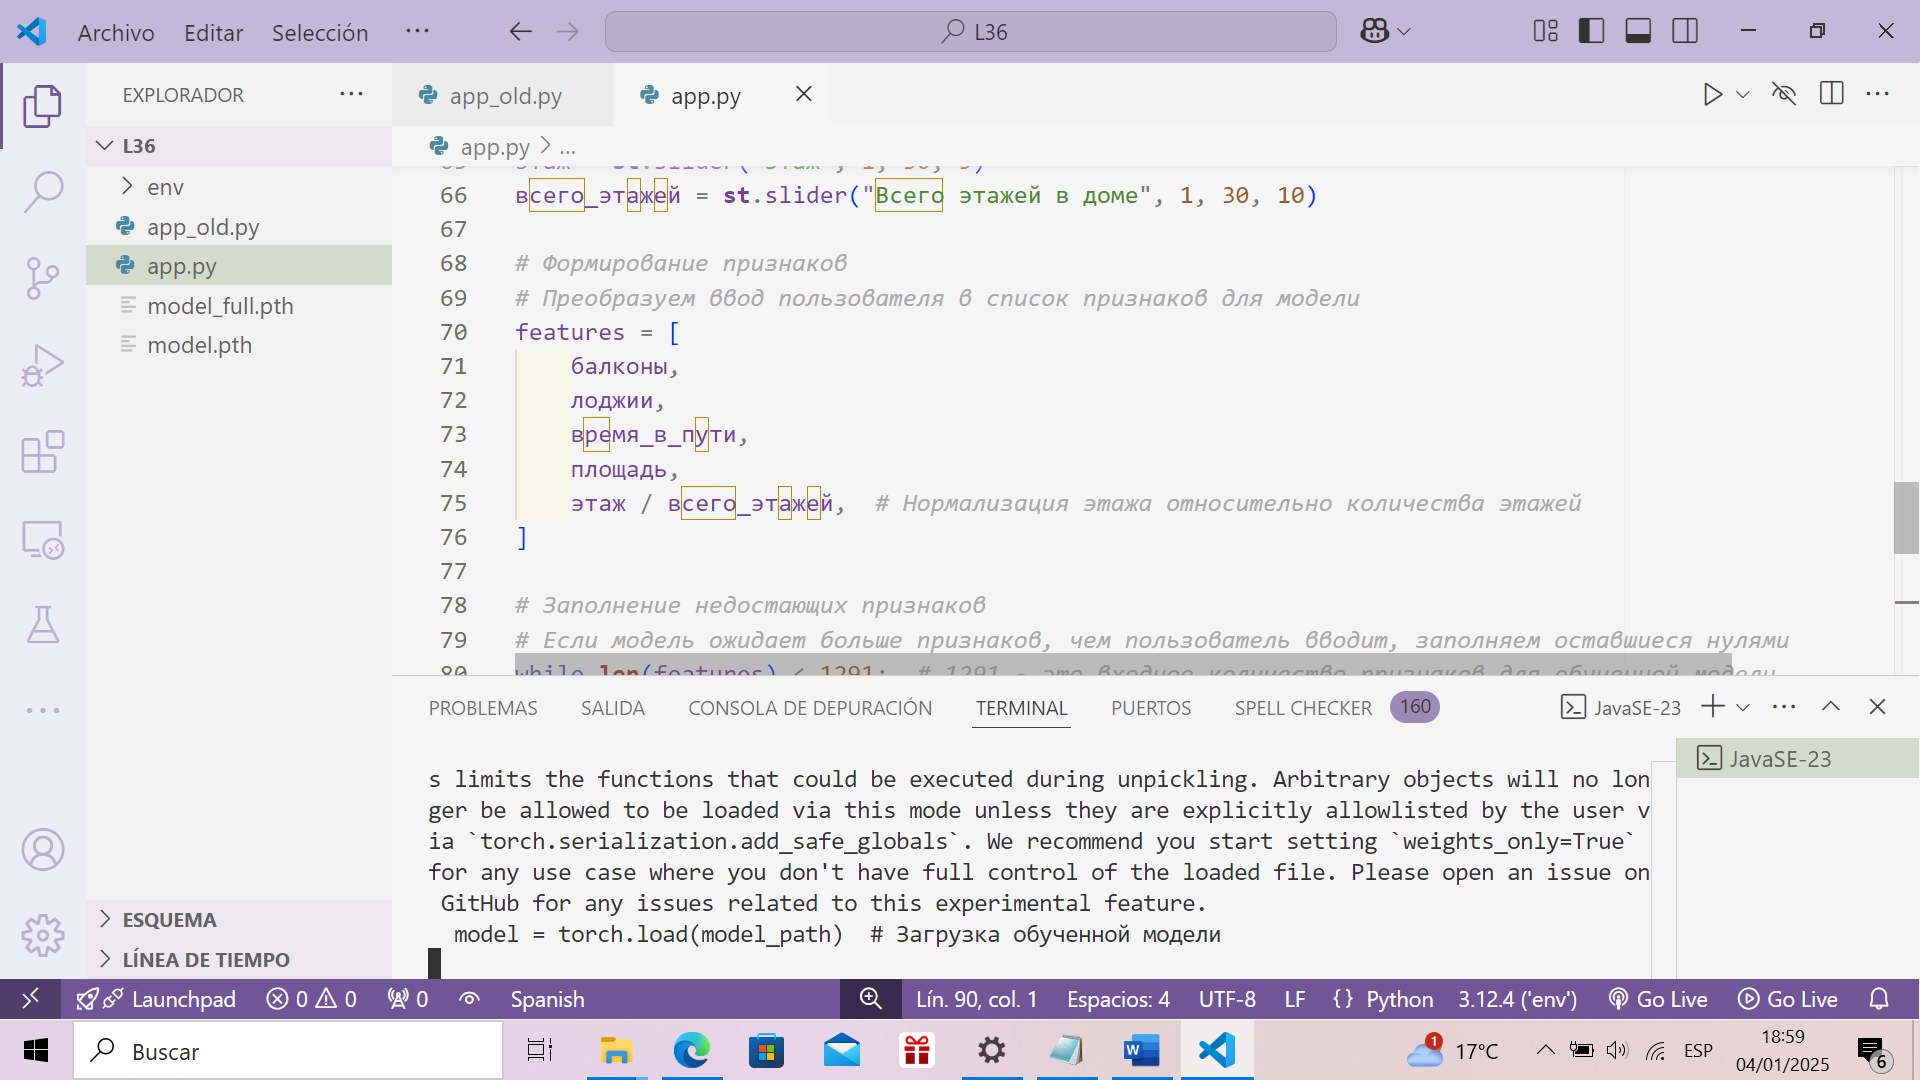